In [1]:
# Allows imports from modules in the project directory
import os
import sys
from pathlib import Path

CURRENT_DIRECTORY = Path(os.path.abspath('')).resolve()
MODULE_DIRECTORY = CURRENT_DIRECTORY.parent
PROJECT_DIRECTORY = MODULE_DIRECTORY.parents[1]
sys.path.extend([str(MODULE_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')

Python 3.9.19 (main, Jul  7 2024, 08:52:44) 
[Clang 15.0.0 (clang-1500.3.9.4)] on darwin


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import utilities

In [3]:
# Load and split dataset
data, labels, fids, velocities, angles = utilities.load_dataset(MODULE_DIRECTORY / 'data/data_adp.pkl')
train_idx, test_idx, train_data, test_data = utilities.split_dataset(fids, labels, data, seed=42)
test_labels = labels[test_idx]

# Normalize dataset
utilities.normalize_data(test_data)

In [4]:
# Data generator allows to transform each batch in training and evaluate the test set after each epoch
class DataGenerator(utilities.BaseDataGenerator):
    # Pad each batch to the maximum length
    def transform(self, X: list) -> np.ndarray:
        maxlength = 0
        for item in X:
            maxlength = max(maxlength, len(item))

        return utilities.pad_data(X, maxlength)

In [5]:
# Initialize data generators
test_generator = DataGenerator(test_data, test_labels, batch_size=32, shuffle=False)

In [6]:
# Load the CNN model
model = tf.keras.models.load_model(str(CURRENT_DIRECTORY / 'models/best_fcn'))

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

210/210 [==============================] - 3s 14ms/step - loss: 0.0147 - accuracy: 0.9964
Test accuracy: 0.9964285492897034


In [8]:
# Get the one-hot encoded test labels and create a new generator
test_labels = tf.keras.utils.to_categorical(labels[test_idx], 4)
generator = DataGenerator(test_data, test_labels, batch_size=1, shuffle=False)

onehot_predictions = model.predict(generator)
predictions = tf.argmax(onehot_predictions, axis=1)

6747/6747 [==============================] - 11s 2ms/step


In [11]:
# Calculate the confusion matrix
confusion_matrix = tf.math.confusion_matrix(
    labels=labels[test_idx],
    predictions=predictions,
    num_classes=4,
).numpy()

print('Confusion Matrix:', confusion_matrix, sep='\n')

Confusion Matrix:
[[ 839    0    0    0]
 [   2 1575    0    1]
 [   3    3 2539    2]
 [   0    7    1 1775]]


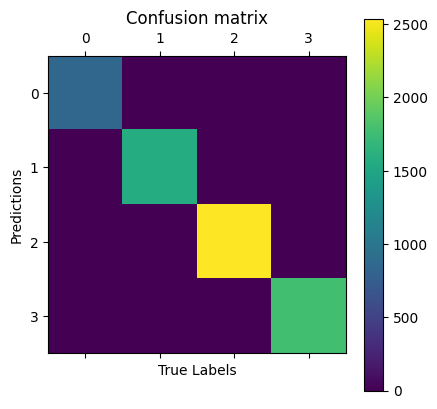

In [12]:
# Show the confusion matrix
plt.matshow(confusion_matrix)
plt.title('Confusion matrix')
plt.ylabel('Predictions')
plt.xlabel('True Labels')
plt.colorbar()
plt.show()

In [13]:
# Evaluate the MCC on the test set
mcc = utilities.matthews_correlation(confusion_matrix)
print('MCC:', mcc)

MCC: 0.996078827179672


In [14]:
pred = tf.constant(onehot_predictions)
true = tf.constant(test_labels)

# Evaluate the loss on the test set
loss = utilities.weighted_loss(true, pred).numpy()
print('Weighted Loss:', loss)

Weighted Loss: 0.02252897
